## Problem: Detection of aggressive tweets

Training dataset has 16000 tweets (in english) which are labeled (by human) as:
* 1 (Cyber-Aggressive; 9714 items)
* 0 (Non Cyber-Aggressive; 6286 items)

# Classification of Tweets

### Dividing data into the training and test part

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_json('./Data/train.json')

In [3]:
X = data.content
y = data.label

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

### Advanced Preprocessing

In [5]:
from sklearn.base import TransformerMixin, BaseEstimator
import nltk
import string
import re

In [6]:
class AdvancedTextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, stopwords=[], punctuation='', stemming=True):
        self.stopwords = stopwords
        self.punctuation = punctuation
        self.stemming = stemming
    
    def fit(self, X, y=None):
        self.stopwords_set = set(self.stopwords)
        self.punctuation_set = set(self.punctuation)
        if self.stemming:
            self.stemmer = nltk.PorterStemmer()
        return self
    
    def get_happy_emoticons(self, X, normalize=False):
        # happy face or heart
        regex = '[:;=8x]-?[)D\\]*]|<3'
        emoticons = [' '.join(re.findall(regex, doc)) for doc in X]
        
        # normalize happy faces --> :)
        if normalize:
            emoticons = [re.sub('[;=8x]', ':', doc) for doc in emoticons]
            emoticons = [re.sub('[D\\]*]', ')', doc) for doc in emoticons]
            emoticons = [re.sub('-', '', doc) for doc in emoticons]
            
        return emoticons

    def get_question_marks(self, X):
        # one or more question marks
        regex = '\\?{1,}'
        question_marks = [' '.join(re.findall(regex, doc)) for doc in X]
        return question_marks
    
    def transform(self, X):        
        # keep happy faces and hearts
        emoticons = self.get_happy_emoticons(X)
        # keep one or more question marks
        question_marks = self.get_question_marks(X)
        
        # convert to lowercase
        X_lower = [doc.lower() for doc in X]
        # split texts into words
        X_tokenized = [nltk.word_tokenize(doc) for doc in X_lower]
        # remove punctuation and stopwords
        X_tokenized = [[token for token in doc_tokenized 
                        if token not in self.punctuation_set and token not in self.stopwords_set]
                      for doc_tokenized in X_tokenized]
        
        # leave stems of words
        if self.stemming:
            X_tokenized = [[self.stemmer.stem(token) for token in doc_tokenized]
                          for doc_tokenized in X_tokenized]
            
        # join list of stems/words, emoticons and question marks
        X_preprocessed = [' '.join(doc_tokenized + [emoticons[i], question_marks[i]])
                          for i, doc_tokenized in enumerate(X_tokenized)]
        
        return X_preprocessed

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from myUtils import *

In [8]:
STOPWORDS = nltk.corpus.stopwords.words('english')
IRRELEVANT_STOPWORDS = pd.read_csv('./Data/irrelevant_stopwords.csv', header=None).T.values[0]
PUNCTUATION = string.punctuation

In [9]:
emoticon_regex = '[:;=8x]-?[)D\\]*]|<3'
question_mark_regex = '\\?{1,}'
advanced_token_pattern = '|'.join(['(?u)\\b'+ emoticon_regex, question_mark_regex, '\\w{2,}\\b'])

pipe_advanced_baseline = Pipeline([
                ('preprocessor', AdvancedTextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                          punctuation=PUNCTUATION,
                                                          stemming=True)),
                ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression(penalty='l2', C=1.0))
                ])

In [10]:
pipe_advanced_baseline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', AdvancedTextPreprocessor(punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
             stemming=True,
             stopwords=array(['above', 'after', ..., 'yourself', 'yourselves'], dtype=object))), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [11]:
y_train_pred = pipe_advanced_baseline.predict(X_train)
y_test_pred = pipe_advanced_baseline.predict(X_test)

Slight improvement (baseline model: accuracy = 0.792)

In [12]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.907
Test dataset: accuracy = 0.799


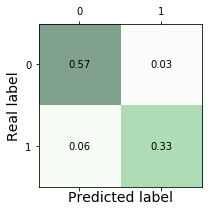

In [13]:
plot_confusion_matrix(y_train, y_train_pred)

But it is still overfitted

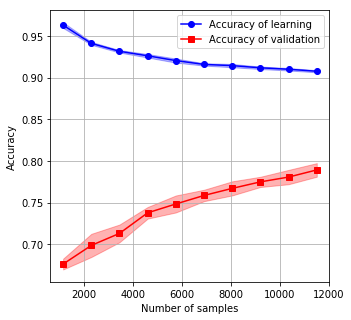

In [14]:
plot_learning_curve(estimator=pipe_advanced_baseline, X=X_train, y=y_train)

### Hyperparameter Tuning

In [32]:
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

import pprint

#### CountVectorizer: Term Frequency

In [16]:
pipe = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern)),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression())
                ])

In [17]:
param_dist = {'preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
              'preprocessor__stemming': [True, False],
              'vectorizer__max_df': uniform(0.5, 0.5),
              'vectorizer__min_df': uniform(0., 0.1),
              'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.)
              }

In [18]:
rs_tf_lr = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                              n_iter=20, n_jobs=1, refit=True,
                              scoring='accuracy',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

In [19]:
rs_tf_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', AdvancedTextPreprocessor(punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
             stemming=True, stopwords=[])), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'preprocessor__stopwords': [array(['above', 'after', ..., 'yourself', 'yourselves'], dtype=object), ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself... ['l1', 'l2'], 'clf__C': <scipy.stats._distn_infrastructure.rv_

In [20]:
rs_tf_lr.best_score_

0.7540625

In [21]:
print('Tarining dataset: accuracy = %.3f' % rs_tf_lr.score(X_train, y_train))
print('Test dataset: accuracy = %.3f' % rs_tf_lr.score(X_test, y_test))

Tarining dataset: accuracy = 0.847
Test dataset: accuracy = 0.753


We can look at the learning and validation curve to check overfitting/underfitting

In [23]:
pprint.pprint(rs_tf_lr.best_params_)

{'clf__C': 2.0727783281955094,
 'clf__penalty': 'l1',
 'preprocessor__stemming': False,
 'preprocessor__stopwords': array(['above', 'after', 'again', 'against', 'aren', "aren't", 'because',
       'being', 'below', 'between', 'both', 'couldn', "couldn't", 'didn',
       "didn't", "doesn't", 'doing', "don't", 'down', 'each', 'few',
       'further', 'hadn', "hadn't", 'hasn', "hasn't", "haven't", 'having',
       'herself', 'him', 'himself', 'his', 'into', 'isn', "isn't",
       'itself', 'mightn', "mightn't", 'mustn', "mustn't", 'myself',
       'needn', "needn't", 'nor', 'off', 'ourselves', 'over', 'same',
       'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn',
       "shouldn't", 'such', "that'll", 'theirs', 'them', 'themselves',
       'then', 'these', 'they', 'those', 'through', 'until', 'up', 'wasn',
       "wasn't", 'weren', "weren't", 'while', 'whom', 'will', 'won',
       "won't", 'wouldn', "wouldn't", "you'd", "you'll", "you've",
       'yours', 'yourself', '

In [24]:
pipe_tf_lr = rs_tf_lr.best_estimator_

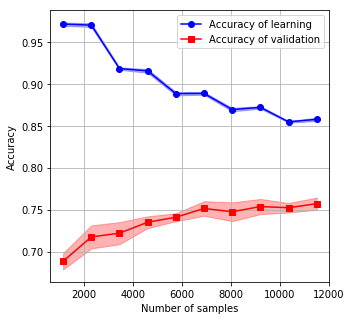

In [25]:
plot_learning_curve(estimator=pipe_tf_lr, X=X_train, y=y_train)

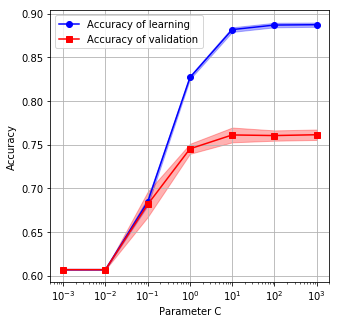

In [26]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

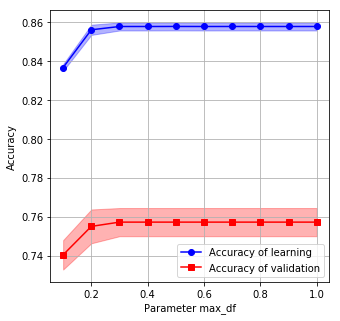

In [27]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__max_df', param_range=np.linspace(0.1, 1., 10))

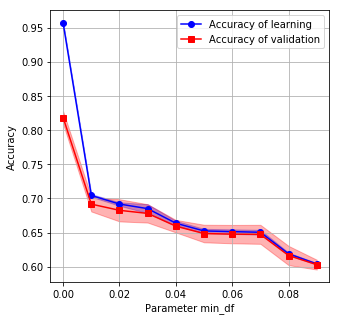

In [28]:
plot_validation_curve(estimator=pipe_tf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__min_df', param_range=np.linspace(0., 0.09, 10))

In [33]:
pprint.pprint(rs_tf_lr.best_params_)

{'clf__C': 2.0727783281955094,
 'clf__penalty': 'l1',
 'preprocessor__stemming': False,
 'preprocessor__stopwords': array(['above', 'after', 'again', 'against', 'aren', "aren't", 'because',
       'being', 'below', 'between', 'both', 'couldn', "couldn't", 'didn',
       "didn't", "doesn't", 'doing', "don't", 'down', 'each', 'few',
       'further', 'hadn', "hadn't", 'hasn', "hasn't", "haven't", 'having',
       'herself', 'him', 'himself', 'his', 'into', 'isn', "isn't",
       'itself', 'mightn', "mightn't", 'mustn', "mustn't", 'myself',
       'needn', "needn't", 'nor', 'off', 'ourselves', 'over', 'same',
       'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn',
       "shouldn't", 'such', "that'll", 'theirs', 'them', 'themselves',
       'then', 'these', 'they', 'those', 'through', 'until', 'up', 'wasn',
       "wasn't", 'weren', "weren't", 'while', 'whom', 'will', 'won',
       "won't", 'wouldn', "wouldn't", "you'd", "you'll", "you've",
       'yours', 'yourself', '

In [31]:
pipe_tf_lr.steps

[('preprocessor',
  AdvancedTextPreprocessor(punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
               stemming=False,
               stopwords=array(['above', 'after', ..., 'yourself', 'yourselves'], dtype=object))),
 ('vectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.5114445807659727, max_features=None,
          min_df=0.0004167306476976718, ngram_range=(1, 1),
          preprocessor=None, stop_words=None, strip_accents=None,
          token_pattern='(?u)\\b[:;=8x]-?[)D\\]*]|<3|\\?{1,}|\\w{2,}\\b',
          tokenizer=None, vocabulary=None)),
 ('scaler', MaxAbsScaler(copy=True)),
 ('clf',
  LogisticRegression(C=2.0727783281955094, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', to

In [34]:
pipe_tf_lr2 = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION,
                                                                  stemming=False,
                                                                  stopwords=IRRELEVANT_STOPWORDS)),
                        ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern,
                                                       max_df=0.5, min_df=0.003)),
                        ('scaler', MaxAbsScaler()),
                        ('clf', LogisticRegression(penalty='l1', C=2))
                        ])

In [35]:
pipe_tf_lr2.fit(X_train, y_train);

In [36]:
y_train_pred = pipe_tf_lr2.predict(X_train)
y_test_pred = pipe_tf_lr2.predict(X_test)

In [37]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.747
Test dataset: accuracy = 0.723


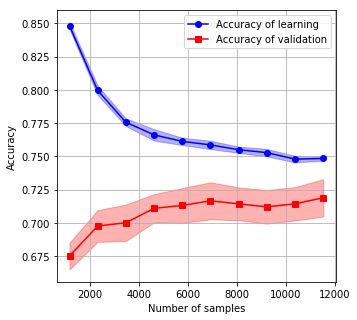

In [38]:
plot_learning_curve(estimator=pipe_tf_lr2, X=X_train, y=y_train)

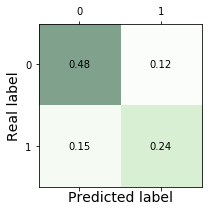

In [63]:
plot_confusion_matrix(y_test, y_test_pred)

In [39]:
import pickle
import os

In [40]:
models_path = './Models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [41]:
# save the model
with open(os.path.join(models_path, 'tf_logistic_regression.p'), 'wb') as file:
    pickle.dump(pipe_tf_lr2, file, protocol=4)

In [42]:
with open(os.path.join(models_path, 'tf_logistic_regression.p'), 'rb') as file:
    loaded_model = pickle.load(file)

In [43]:
loaded_model.score(X_test, y_test)

0.7234375

#### TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
pipe_tfidf_lr = Pipeline([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION)),
                          ('vectorizer', TfidfVectorizer(token_pattern=advanced_token_pattern, norm='l2')),
                          ('clf', LogisticRegression())
                         ])

In [52]:
param_dist = {'preprocessor__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
              'preprocessor__stemming': [True, False],
              'vectorizer__max_df': uniform(0.5, 0.5),
              'vectorizer__min_df': uniform(0., 0.1),
              'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.)
              }

In [53]:
rs_tfidf_lr = RandomizedSearchCV(estimator=pipe_tfidf_lr, param_distributions=param_dist, 
                                 n_iter=20, n_jobs=1, refit=True,
                                 scoring='accuracy',
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

In [54]:
rs_tfidf_lr.fit(X_train, y_train);

In [55]:
rs_tfidf_lr.best_score_

0.717421875

In [56]:
print('Tarining dataset: accuracy = %.3f' % rs_tfidf_lr.score(X_train, y_train))
print('Test dataset: accuracy = %.3f' % rs_tfidf_lr.score(X_test, y_test))

Tarining dataset: accuracy = 0.744
Test dataset: accuracy = 0.724


In [57]:
pprint.pprint(rs_tfidf_lr.best_params_)

{'clf__C': 0.6627234562113027,
 'clf__penalty': 'l1',
 'preprocessor__stemming': False,
 'preprocessor__stopwords': ['i',
                             'me',
                             'my',
                             'myself',
                             'we',
                             'our',
                             'ours',
                             'ourselves',
                             'you',
                             "you're",
                             "you've",
                             "you'll",
                             "you'd",
                             'your',
                             'yours',
                             'yourself',
                             'yourselves',
                             'he',
                             'him',
                             'his',
                             'himself',
                             'she',
                             "she's",
                             'her',
            

In [58]:
pipe_tfidf_lr = rs_tfidf_lr.best_estimator_

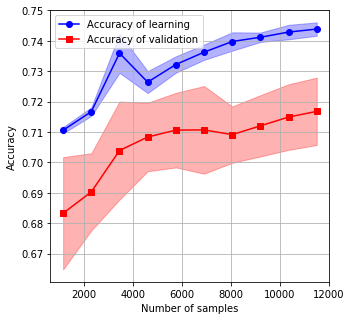

In [59]:
plot_learning_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train)

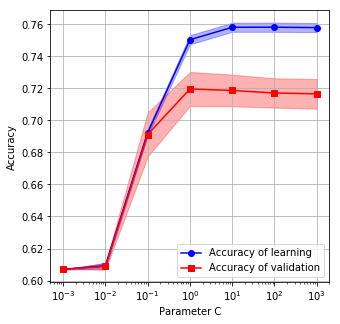

In [60]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

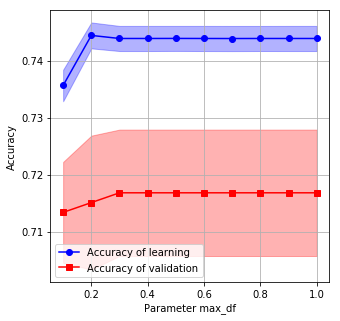

In [61]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__max_df', param_range=np.linspace(0.1, 1., 10))

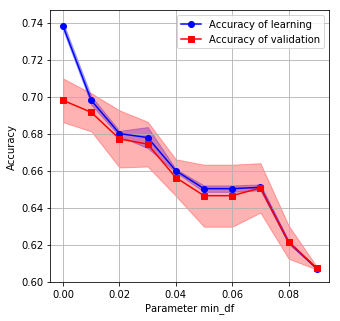

In [62]:
plot_validation_curve(estimator=pipe_tfidf_lr, X=X_train, y=y_train, 
                      param_name='vectorizer__min_df', param_range=np.linspace(0., 0.09, 10))

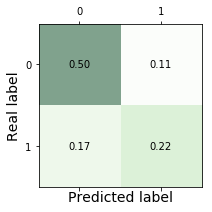

In [64]:
plot_confusion_matrix(y_test, rs_tfidf_lr.predict(X_test))

In [22]:

from sklearn.pipeline import FeatureUnion

In [ ]:
# clf_tf_lr2 = pipe_tf_lr2.named_steps['clf']

In [ ]:
# pipe_tf_trans = FeatureUnion([('preprocessor', AdvancedTextPreprocessor(punctuation=PUNCTUATION,
#                                                                            stemming=True,
#                                                                            stopwords=IRRELEVANT_STOPWORDS)),
#                                  ('vectorizer', CountVectorizer(token_pattern=advanced_token_pattern,
#                                                                 max_df=0.65, min_df=0.0003)),
#                                  ('scaler', MaxAbsScaler())
#                                 ])

# pipe_tf_lr = Pipeline([('transformers', pipe_tf_trans),
#                        ('clf', LogisticRegression(penalty='l2', C=))
#                       ])